In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, Aer, transpile, execute
from qiskit.visualization import plot_histogram
from qiskit.circuit.library.standard_gates import RZGate, SXGate, XGate, CXGate, IGate, YGate, ZGate

## 1. Function to add noise

In [2]:
def add_pauli_noise(alpha, beta, circuit):
   
    noisy_circuit = QuantumCircuit(circuit.num_qubits, circuit.num_clbits) #Create a new circuit
    
                                          
    for instr, qargs, cargs in circuit:    # Iterate over all operations in the circuit
        # Add the original gate to the new circuit
        noisy_circuit.append(instr, qargs, cargs)
        
        # Determine if the gate is one-qubit or two-qubit
        if len(qargs) == 1:
            # One-qubit gate, add noise with probability alpha
            if random.random() < alpha:
                # Apply a random Pauli gate (X, Y, Z)
                pauli_gate = random.choice([XGate(), YGate(), ZGate()])
                noisy_circuit.append(pauli_gate, [qargs[0]])
        
        elif len(qargs) == 2:
            # Two-qubit gate, add noise with probability beta
            if random.random() < beta:
                # Apply a random Pauli gate (X, Y, Z) to both qubits
                for qubit in qargs:
                    pauli_gate = random.choice([XGate(), YGate(), ZGate()])
                    noisy_circuit.append(pauli_gate, [qubit])
                    
    return noisy_circuit

## 2. Transform the Circuit to target gate basis

In [3]:
def transform(circuit):

    backend = Aer.get_backend('qasm_simulator')
    
    # Define the target gate basis: {CX, ID, RZ, SX, X}
    basis_gates = ['cx', 'id', 'rz', 'sx', 'x']
    
    # Transpile the circuit to the specified basis
    tqc = transpile(qc, backend=backend, basis_gates=basis_gates)
    
    return tqc
    
    

## 3. Drapper Adder Algorithm 

In [4]:
def swap(qc, qubits):
    n = len(qubits)
    for i in range(n//2):             
       qc.swap(qubits[i], qubits[n - i - 1])
def custom_qft(qc, qubits):
    n = len(qubits)
    for i in range(n//2):             #Apply inverse QFT to the circuit
       qc.swap(qubits[i], qubits[n - i - 1])
    for i in range(n):
        qc.h(qubits[i])  # Apply Hadamard gate
        for j in range(i + 1, n):
            theta = np.pi / (2 ** (j - i))
            qc.cp(theta, qubits[j], qubits[i])  # Controlled phase rotation
def custom_inverse_qft(qc, qubits):
    n = len(qubits)
    for i in range(n//2):            #Apply inverse QFT to the circuit
        qc.swap(qubits[i], qubits[n - i - 1])
                          
    for i in range(n):
        for j in range(i):
            theta = -np.pi / (2 ** (i-j) )
            qc.cp(theta, qubits[j], qubits[i])  # Controlled phase rotation
        qc.h(qubits[i])  # Apply Hadamard gate


def controlled_phase_rotations(qc, a, b, n):
    print(a, b)
  
    for i in range(n):
        for j in range(i, n):
            # Phase angle is scaled by the difference in qubit positions
            theta = np.pi / (2 ** (j - i ))
            qc.cp(theta, b[j], a[i])  # Controlled phase rotation from a[i] to b[j]

# Draper adder using custom QFT
def quantum_sum(a,b, n):
    
    qc = QuantumCircuit(2 * n, n)
    for i in range(n):       #Express a in circuit
       if (a >> i) & 1:
           qc.x(i)
    for i in range(n):       #Express b in circuit
       if (b >> i) & 1:
           qc.x(i + n)
    
    qc.barrier()
    # Apply custom QFT to the first register (source register `a`)
    custom_qft(qc, range(n))
   
    # Apply swap to the second register (target register)
    swap(qc, range(n, 2 * n))
    qc.barrier()
    #Perform controlled phase rotations (add register `a` to register `b`)
    controlled_phase_rotations(qc, range(n), range(n, 2 * n), n)
    qc.barrier()
    # Apply custom inverse QFT to the second register
    custom_inverse_qft(qc, range(n))
    qc.barrier()
    return qc


## 3.1 Testing 

range(0, 6) range(6, 12)
      ┌───┐ ░    ┌───┐                                                   »
 q_0: ┤ X ├─░──X─┤ H ├─■────────■─────────────■─────────────────■────────»
      └───┘ ░  │ └───┘ │P(π/2)  │       ┌───┐ │                 │        »
 q_1: ──────░──┼───X───■────────┼───────┤ H ├─┼────────■────────┼────────»
            ░  │   │            │P(π/4) └───┘ │        │P(π/2)  │        »
 q_2: ──────░──┼───┼──────X─────■─────────────┼────────■────────┼────────»
            ░  │   │      │                   │P(π/8)           │        »
 q_3: ──────░──┼───┼──────X───────────────────■─────────────────┼────────»
      ┌───┐ ░  │   │                                            │P(π/16) »
 q_4: ┤ X ├─░──┼───X────────────────────────────────────────────■────────»
      └───┘ ░  │                                                         »
 q_5: ──────░──X─────────────────────────────────────────────────────────»
      ┌───┐ ░                                                            »


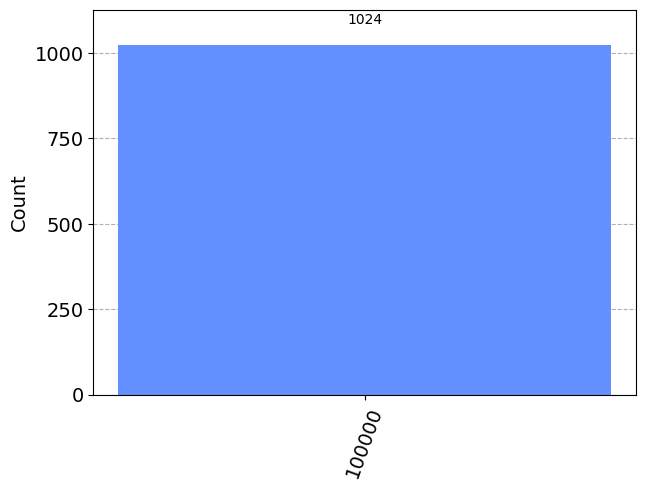

In [39]:
a = 17
b = 15
n = max(len(bin(a))-2, len(bin(b))-2) + 1   #Determine the number of qubit needed
qc = quantum_sum(a, b, n)

# Measure the output
qc.measure(range(n), range(n))

# Draw the circuit
print(qc)

simulator = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(qc, simulator)
result = execute(compiled_circuit, backend=simulator, shots=1024).result()

# Get the measurement result
counts = result.get_counts()
print(counts)

# Plot the result

plot_histogram(counts)

The Draper's Adder Algorithm gives good result without any noise!

## 4. Analyze the effect of transformation and noise

range(0, 5) range(5, 10)
The number of qubits 10
{'00010': 3, '10010': 142, '11010': 288, '01010': 591}


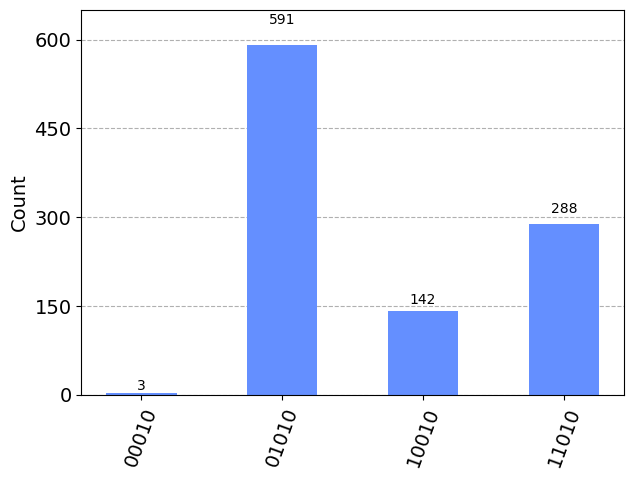

In [47]:
a = 8
b = 8
n = max(len(bin(a))-2, len(bin(b))-2) + 1   #Determine the number of qubit needed
qc = quantum_sum(a, b, n)
#qc = transform(qc)
alpha = 0.01
beta = 0.01
#qc = add_pauli_noise_to_circuit(alpha, beta, qc)
qc = add_pauli_noise(alpha, beta, qc)
print("The number of qubits", qc.num_qubits)
# Measure the output
qc.measure(range(n), range(n))

# Draw the circuit
#print(qc)

simulator = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(qc, simulator)
result = execute(compiled_circuit, backend=simulator, shots=  1024).result()

# Get the measurement result
counts = result.get_counts()
print(counts)

# Plot the result

plot_histogram(counts)

## Summary

In this notebook, Draper's QFT Adder algorim was implemented. Noise was introduced by seperate function and Tranfromation to basis gates is performed with Qiskit Library. After testing with different setups and noise, we can get the following conclusion.
1. Without niose the algorithm give correct result with certainty.
2. Transforming circuit to circuit consists of basis gate without noise, has little effect on result.
3. Noise has determental effect on the final measurement, with small noise the circuit gives correct result in some case, with the increase of noise, the chance of getting correct result is reduced.
4. Transformed circuit become sensetive to noise, that is due the the increased number of  gates in the circuit.

In conclusion, in order to increase the accuracy of circuit, we should optimize the circuit or algorithm to use as less gates as possible. In addition, we shuold ompimize the circuit by using algorithm which uese the native gates of Quantum hardwate.